# Dose Measurement Script

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import cv2
import os

### Film Type & Color Channel

In [2]:
filmtype = "EBT4"  #Enter EBT3 or EBT4
channel = "G"     #Enter G or RGB

## 1. Calibration Curve 


### 1.1 OD calculation

In [3]:
I = np.sort(np.loadtxt(f"calibration/{filmtype}_int_{channel}.txt", skiprows=1, usecols=1)) #Calibration intensities file

OD = []

def ItoOD(x):
    return abs(np.log(min(I)/x))

for i in I:
    OD.append(ItoOD(i))

print(OD)

[0.0, 0.027949020370333467, 0.05841093305719269, 0.18695496877591927, 0.3939625035430226, 0.5122698711641548, 0.6185805321464641, 0.6599507757469245, 0.741446789258232, 0.7925740518891774]


### 1.2 Calibration with calculated OD

**Fit model such as :** $$ D(OD) = \frac{a - c e^{-OD}}{e^{-OD}-b}$$

 fit parameters:  a = 3.010365663714559, b = 0.37208878799668194, c = 3.07160190504093


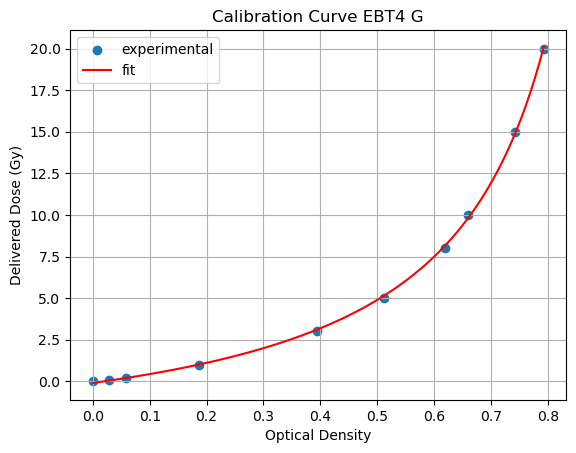

In [4]:
dose_data = np.sort(np.loadtxt(f"calibration/{filmtype}_dose.txt"))  # Calibration doses file

interval = np.linspace(min(OD), max(OD), 100)

def D(x, a, b, c):
    return (a-c*np.exp(-x))/(np.exp(-x)-b)

popt, pcov = curve_fit(D, OD, dose_data, (0, 0, 0), maxfev = 10000)

a, b, c = popt

plt.scatter(OD, dose_data, label='experimental')
plt.plot(interval, D(interval, *popt), label="fit", color="red")
plt.xlabel('Optical Density')
plt.ylabel('Delivered Dose (Gy)')
plt.title(f'Calibration Curve {filmtype} {channel}')
plt.legend()
plt.grid(True)
print(f"\033[1m fit parameters: \033[0m a = {a}, b = {b}, c = {c}")
plt.show()

## 2. Dose Measurement

### 2.1 Eppendorfs with Hg to locate the sample

 Mean intensity square :  174.68166666666667 

 Mean dose square :  8.04 Gy 

 gauss parameters hor:  a = 9.67 Gy, sigma = -5.94 mm, mu = 2.28
 gauss parameters ver:  a = 9.66 Gy, sigma = -5.73 mm, mu = 0.93 



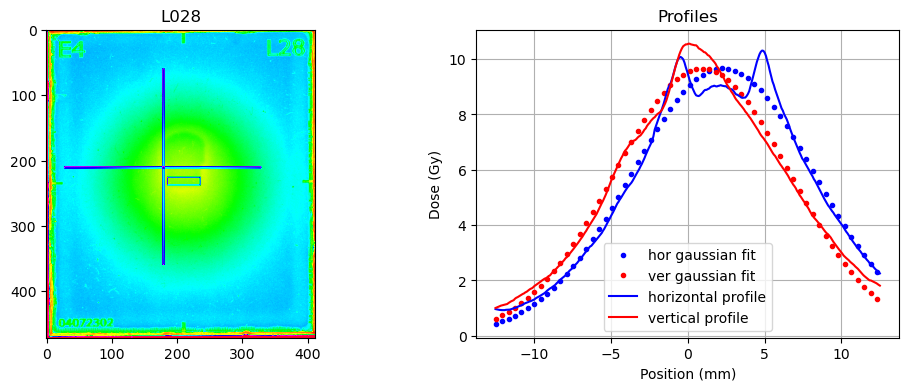

In [70]:
mercury = 'L028'
file = f'ZFE_L/{mercury}.tif'

image = cv2.imread(file)

# Image specs

height, width, channels = image.shape

mm = round(height/40)   # 1mm in pixel

image_g = image[:, :, 1]
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

if channel == "G":
    negative_image = cv2.bitwise_not(image_g)
elif channel == "RGB":
    negative_image = cv2.bitwise_not(image_gray)
else:
    print("channel error")
        

# Locating maximum intensity pixel, gaussian blur to avoid noise

image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

x_zoi, y_zoi = 150, 150

zoi = image_blur[y_zoi:220, x_zoi:220]                  #Defines a restricted search area to better avoid noise

(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

# Max intensity pixel coordinates

maxLoc_x = maxLoc[0] + x_zoi
maxLoc_y = maxLoc[1] + y_zoi                     

# Defining square to measure the dose in

x, y, width, height = 185, 225, 50, 1*mm                  # -> custom square to fit the mercury/ZFE
#x, y, width, height = maxLoc_x-1, maxLoc_y-1, 3, 3       # -> square on center of mass, 3x3 pixels

square = negative_image[y:y+height, x:x+width]

mean_intensity = np.mean(square)                          #Intensity inside defined square


# Profiles

# horizontal slice

x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2
hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

# vertical slice
x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300
ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]

#-> Horizontal and Vertical slices intersect on maximum intensity pixel

# vertical and horizontal intensity per mm 
ver_intensity = []
hor_intensity = []  

for j in range(1,height_ver):
    ver_intensity.append(np.mean(negative_image[y_ver+j:y_ver+j+mm, x_ver:x_ver+width_ver]))
    
for j in range(1,width_hor):
    hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+j:x_hor+j+mm])) 
    
# vertical and horizontal dose per mm
ver_dose = []
hor_dose = []

for j in range(1, height_ver-1):
    ver_dose.append(D(ItoOD(ver_intensity[j]), *popt))

for j in range(1,width_hor-1) :
    hor_dose.append(D(ItoOD(hor_intensity[j]), *popt))

# Display and Gaussian fit 

def gauss(x, a, sigma, mu):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1) #square drawing
result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1) #horizontal slice drawing
result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1) #vertical slice drawing

print("\033[1m Mean intensity square : \033[0m", mean_intensity, "\n")
print("\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy \n")

fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs = axs.ravel()

interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
interval_mm = interval / mm  

dose = round(D(ItoOD(mean_intensity), *popt), 2)


if dose > 1:  #condition to avoid fitting on background films
    
    popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
    popt_ver, pcov_ver = curve_fit(gauss, interval_mm, ver_dose)

    a_hor, sigma_hor, mu_hor = popt_hor
    a_ver, sigma_ver, mu_ver = popt_ver

    axs[1].plot(interval_mm[::5], gauss(interval_mm[::5], *popt_hor),".", color="blue",  label="hor gaussian fit")
    axs[1].plot(interval_mm[::5], gauss(interval_mm[::5], *popt_ver),".", color="red",  label="ver gaussian fit")

    print(f"\033[1m gauss parameters hor: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)}")
    print(f"\033[1m gauss parameters ver: \033[0m a = {round(a_ver, 2)} Gy, sigma = {round(sigma_ver, 2)} mm, mu = {round(mu_ver, 2)} \n")


axs[0].imshow(result, cmap="hsv_r")
axs[0].set_title(mercury)

axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
axs[1].set_xlabel("Position (mm)")
axs[1].set_ylabel("Dose (Gy)")
axs[1].set_title("Profiles")
axs[1].grid(True)
axs[1].legend()

plt.show()

### 2.2 Dose Measurement of a whole batch

 Mean dose square :  9.13 Gy 

 gauss parameters hor:  a = 8.98 Gy, sigma = -5.4 mm, mu = 0.1
 gauss parameters ver:  a = 9.34 Gy, sigma = -5.38 mm, mu = 1.12 

(maxLoc_x, maxLoc_y) = (196, 210)


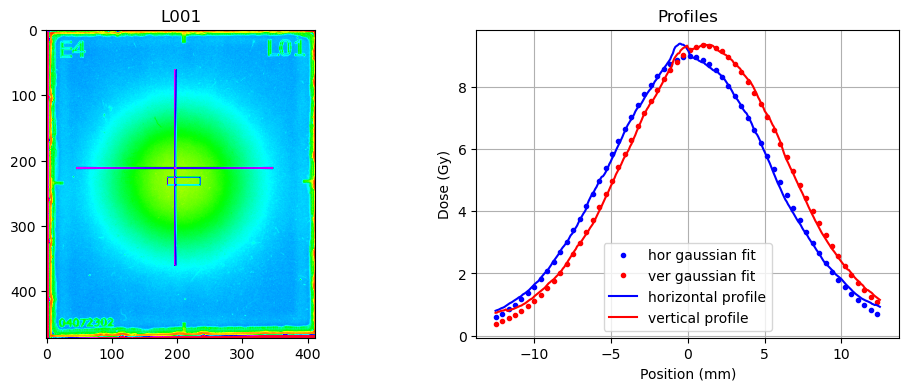

 Mean dose square :  7.91 Gy 

 gauss parameters hor:  a = 7.6 Gy, sigma = 5.84 mm, mu = -0.23
 gauss parameters ver:  a = 7.97 Gy, sigma = 5.86 mm, mu = 1.4 

(maxLoc_x, maxLoc_y) = (203, 208)


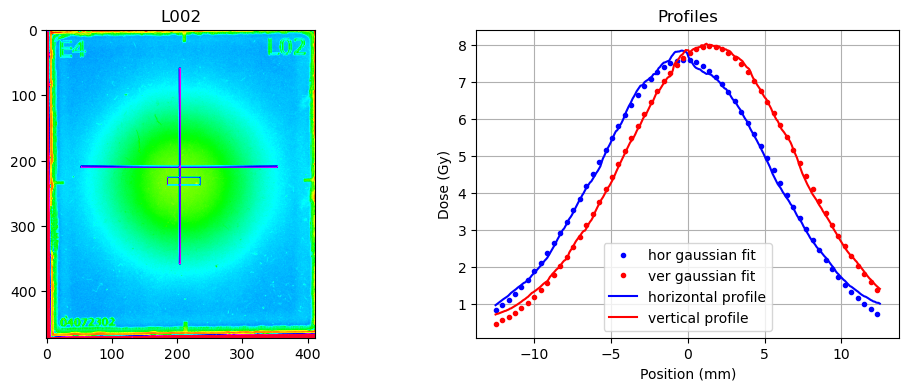

 Mean dose square :  9.16 Gy 

 gauss parameters hor:  a = 9.23 Gy, sigma = -5.35 mm, mu = -0.25
 gauss parameters ver:  a = 9.36 Gy, sigma = -5.39 mm, mu = 0.41 

(maxLoc_x, maxLoc_y) = (202, 218)


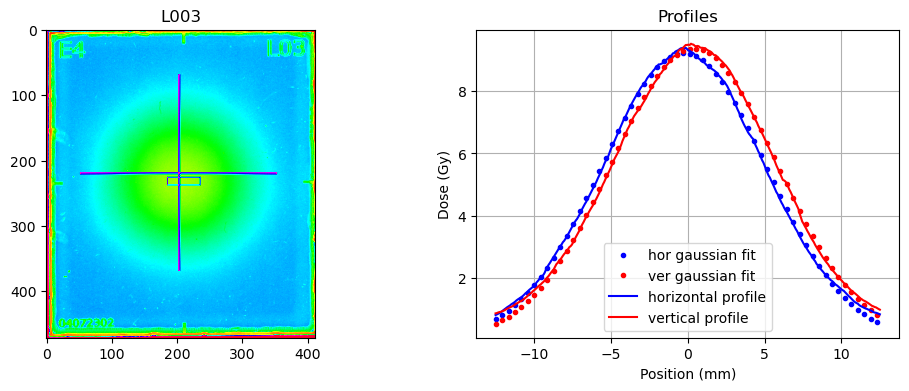

 Mean dose square :  7.87 Gy 

 gauss parameters hor:  a = 7.87 Gy, sigma = 5.75 mm, mu = -0.06
 gauss parameters ver:  a = 8.04 Gy, sigma = 5.75 mm, mu = 0.46 

(maxLoc_x, maxLoc_y) = (201, 216)


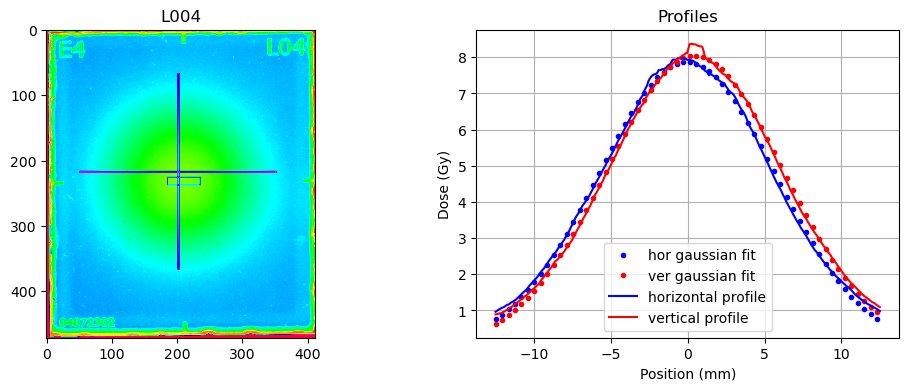

 Mean dose square :  9.17 Gy 

 gauss parameters hor:  a = 9.19 Gy, sigma = -5.41 mm, mu = 0.17
 gauss parameters ver:  a = 9.35 Gy, sigma = -5.4 mm, mu = 0.45 

(maxLoc_x, maxLoc_y) = (197, 218)


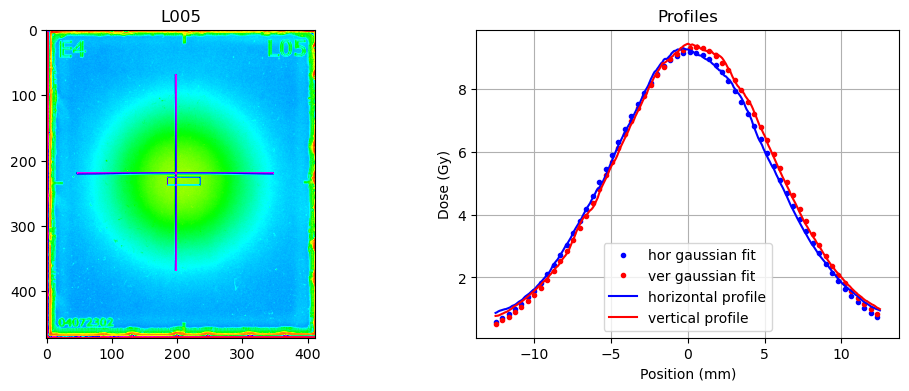

 Mean dose square :  7.96 Gy 

 gauss parameters hor:  a = 7.84 Gy, sigma = 5.85 mm, mu = -0.28
 gauss parameters ver:  a = 8.17 Gy, sigma = 5.86 mm, mu = 0.97 

(maxLoc_x, maxLoc_y) = (205, 210)


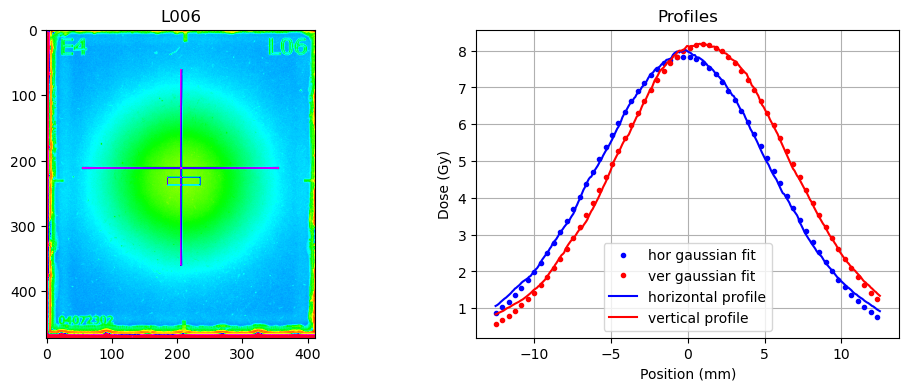

 Mean dose square :  10.33 Gy 

 gauss parameters hor:  a = 10.31 Gy, sigma = 5.37 mm, mu = -0.15
 gauss parameters ver:  a = 10.62 Gy, sigma = 5.34 mm, mu = 0.77 

(maxLoc_x, maxLoc_y) = (199, 216)


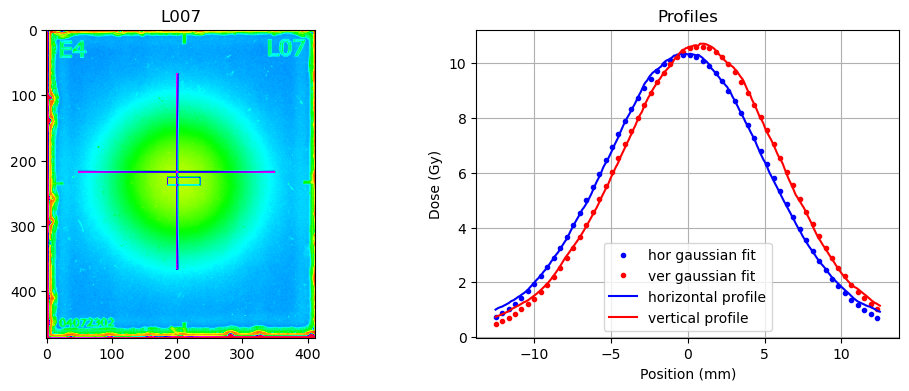

 Mean dose square :  9.06 Gy 

 gauss parameters hor:  a = 9.04 Gy, sigma = -5.83 mm, mu = -0.47
 gauss parameters ver:  a = 9.28 Gy, sigma = -5.83 mm, mu = 0.66 

(maxLoc_x, maxLoc_y) = (206, 217)


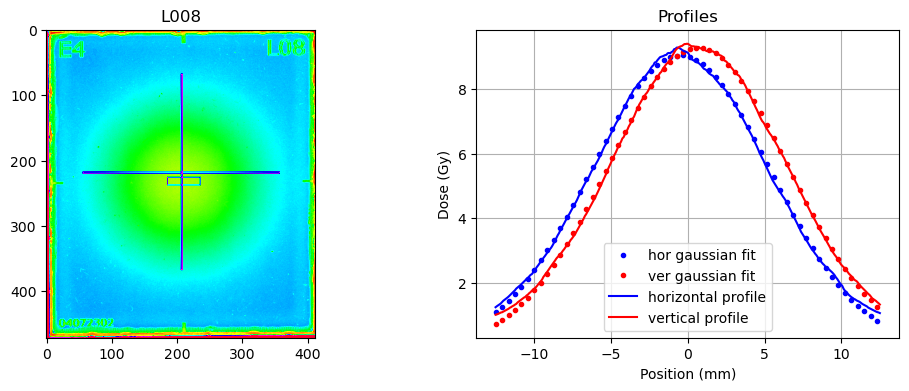

 Mean dose square :  10.5 Gy 

 gauss parameters hor:  a = 10.57 Gy, sigma = 5.46 mm, mu = 0.1
 gauss parameters ver:  a = 10.65 Gy, sigma = 5.41 mm, mu = 0.52 

(maxLoc_x, maxLoc_y) = (199, 216)


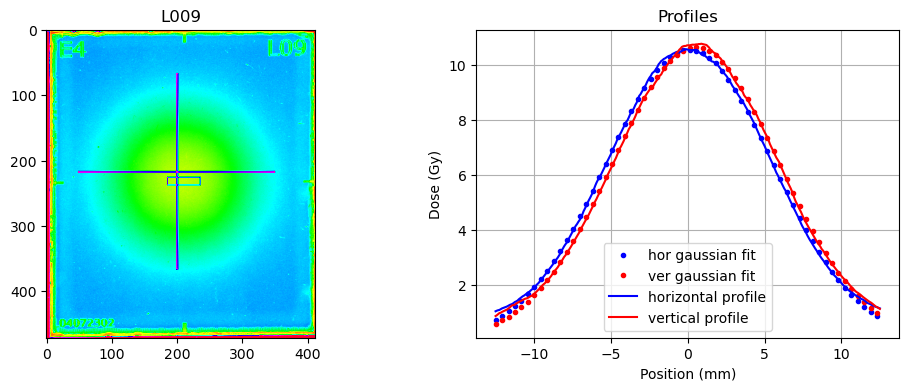

 Mean dose square :  9.18 Gy 

 gauss parameters hor:  a = 9.09 Gy, sigma = -5.85 mm, mu = -0.41
 gauss parameters ver:  a = 9.42 Gy, sigma = -5.82 mm, mu = 0.72 

(maxLoc_x, maxLoc_y) = (207, 216)


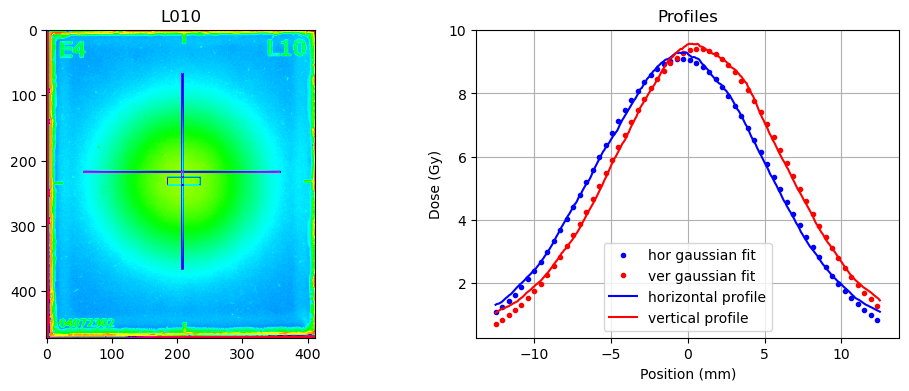

 Mean dose square :  10.46 Gy 

 gauss parameters hor:  a = 10.57 Gy, sigma = 5.44 mm, mu = 0.26
 gauss parameters ver:  a = 10.74 Gy, sigma = 5.4 mm, mu = 0.53 

(maxLoc_x, maxLoc_y) = (190, 216)


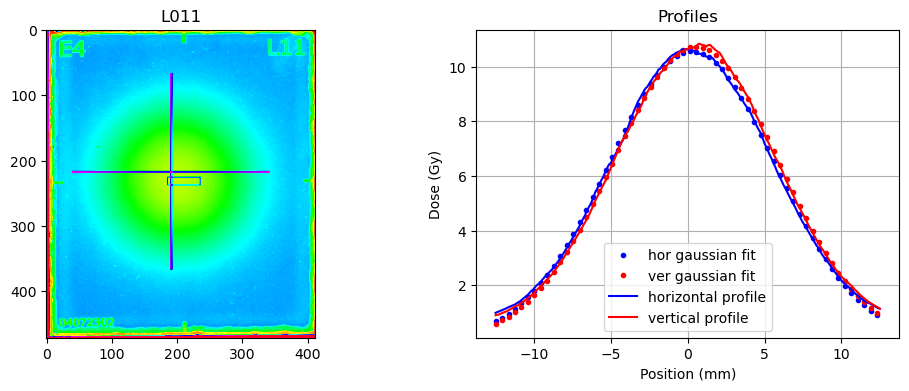

 Mean dose square :  9.24 Gy 

 gauss parameters hor:  a = 9.2 Gy, sigma = -5.92 mm, mu = -0.13
 gauss parameters ver:  a = 9.46 Gy, sigma = -5.9 mm, mu = 0.79 

(maxLoc_x, maxLoc_y) = (197, 218)


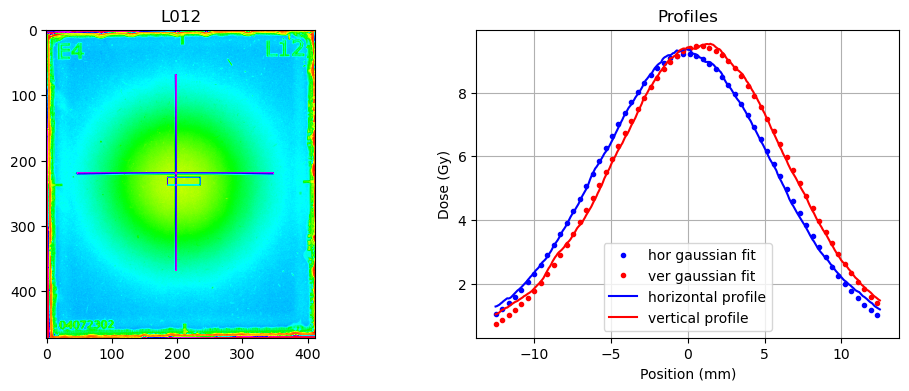

 Mean dose square :  8.17 Gy 

 gauss parameters hor:  a = 8.11 Gy, sigma = 5.76 mm, mu = 0.06
 gauss parameters ver:  a = 8.39 Gy, sigma = 5.71 mm, mu = 0.83 

(maxLoc_x, maxLoc_y) = (195, 213)


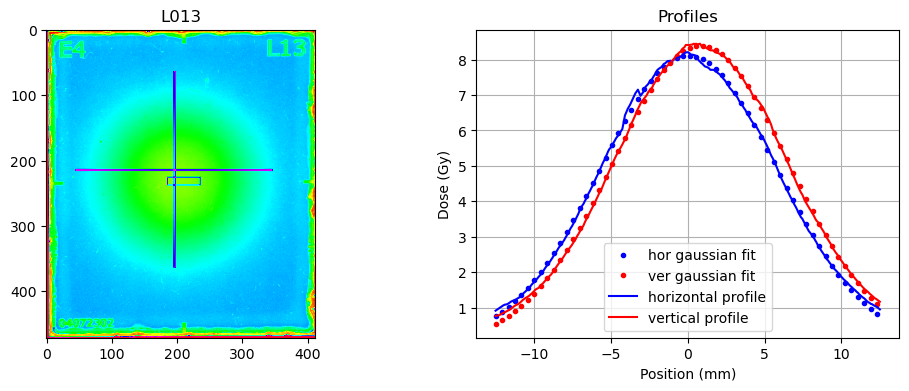

 Mean dose square :  7.14 Gy 

 gauss parameters hor:  a = 7.13 Gy, sigma = 6.05 mm, mu = -0.13
 gauss parameters ver:  a = 7.28 Gy, sigma = 6.06 mm, mu = 0.82 

(maxLoc_x, maxLoc_y) = (202, 212)


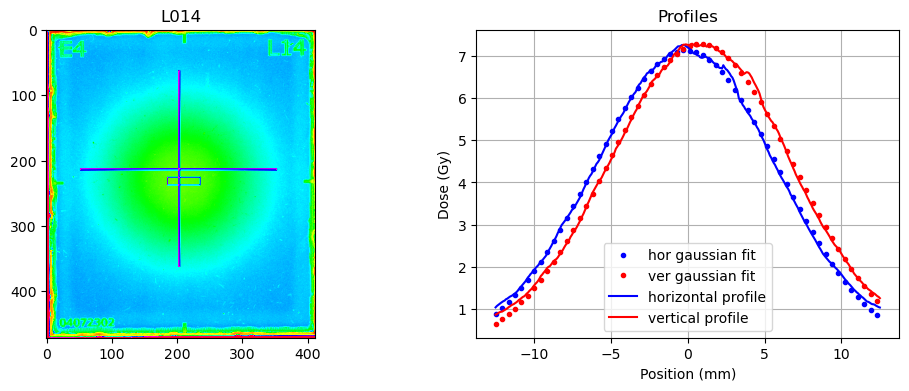

 Mean dose square :  7.72 Gy 

 gauss parameters hor:  a = 7.79 Gy, sigma = 5.66 mm, mu = -0.53
 gauss parameters ver:  a = 7.93 Gy, sigma = 5.63 mm, mu = 0.39 

(maxLoc_x, maxLoc_y) = (209, 214)


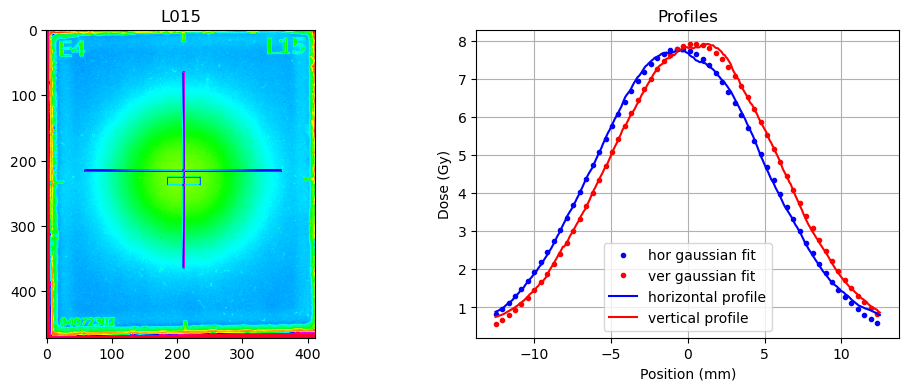

 Mean dose square :  6.83 Gy 

 gauss parameters hor:  a = 6.93 Gy, sigma = 6.08 mm, mu = -0.33
 gauss parameters ver:  a = 6.96 Gy, sigma = 6.06 mm, mu = 0.47 

(maxLoc_x, maxLoc_y) = (211, 215)


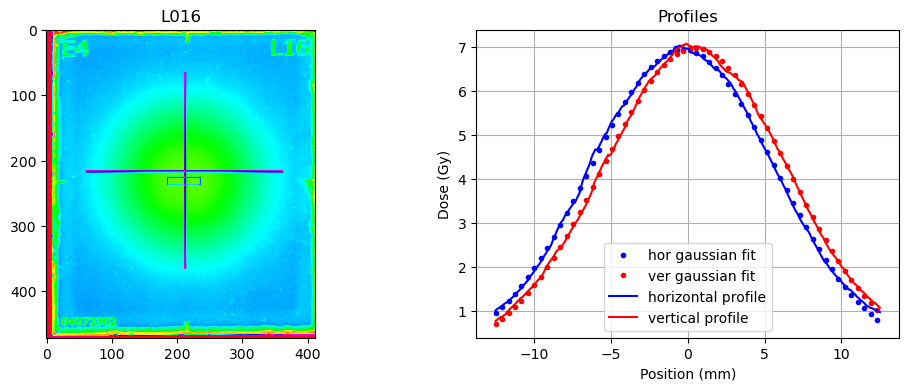

 Mean dose square :  7.65 Gy 

 gauss parameters hor:  a = 7.82 Gy, sigma = 5.68 mm, mu = 0.3
 gauss parameters ver:  a = 7.91 Gy, sigma = 5.61 mm, mu = 0.18 

(maxLoc_x, maxLoc_y) = (197, 219)


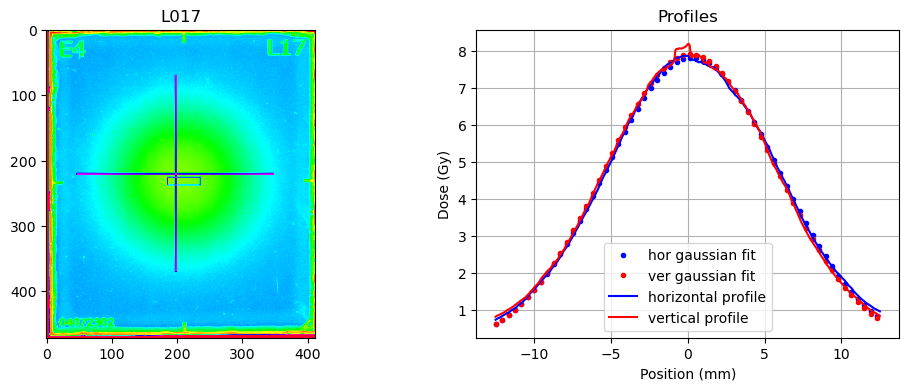

 Mean dose square :  6.88 Gy 

 gauss parameters hor:  a = 6.9 Gy, sigma = 6.06 mm, mu = -0.37
 gauss parameters ver:  a = 7.02 Gy, sigma = 6.02 mm, mu = 0.55 

(maxLoc_x, maxLoc_y) = (208, 216)


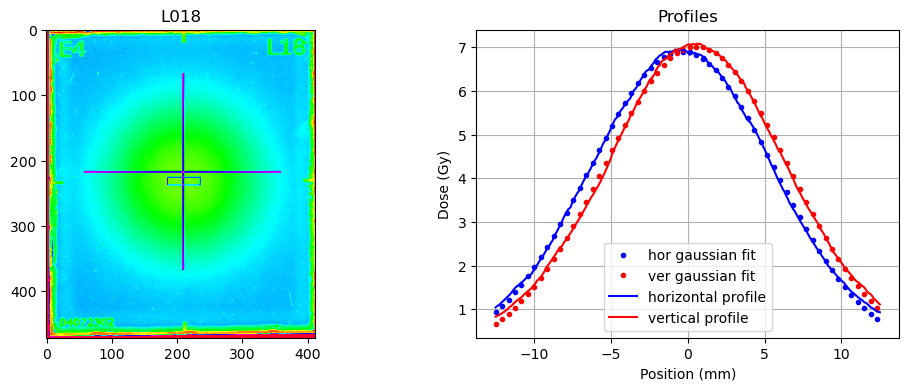

 Mean dose square :  10.13 Gy 

 gauss parameters hor:  a = 10.06 Gy, sigma = 5.69 mm, mu = 0.46
 gauss parameters ver:  a = 10.24 Gy, sigma = 5.67 mm, mu = 0.93 

(maxLoc_x, maxLoc_y) = (194, 210)


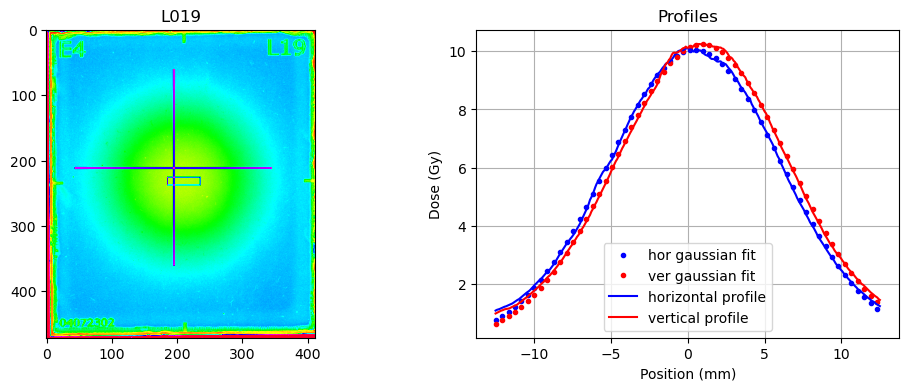

 Mean dose square :  8.73 Gy 

 gauss parameters hor:  a = 8.3 Gy, sigma = 6.05 mm, mu = -0.27
 gauss parameters ver:  a = 8.94 Gy, sigma = 6.06 mm, mu = 1.59 

(maxLoc_x, maxLoc_y) = (206, 204)


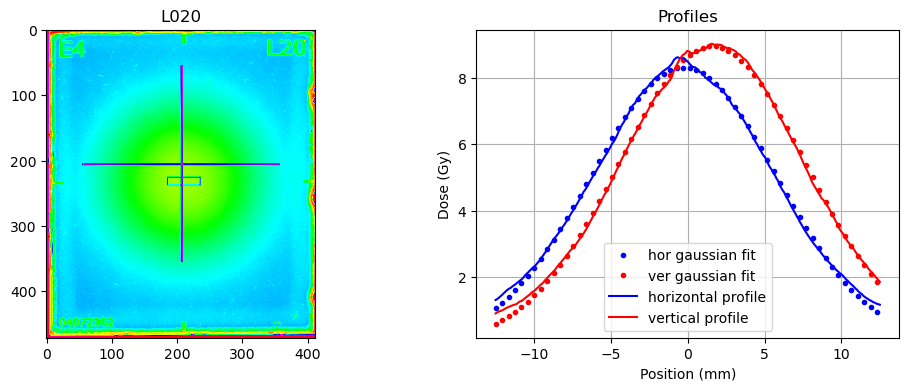

 Mean dose square :  9.67 Gy 

 gauss parameters hor:  a = 9.68 Gy, sigma = -5.67 mm, mu = 0.46
 gauss parameters ver:  a = 9.92 Gy, sigma = -5.67 mm, mu = 0.74 

(maxLoc_x, maxLoc_y) = (193, 212)


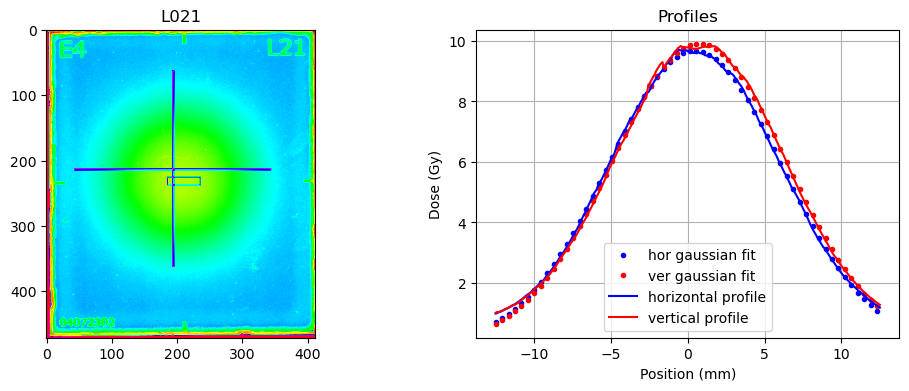

 Mean dose square :  8.36 Gy 

 gauss parameters hor:  a = 8.32 Gy, sigma = 6.04 mm, mu = -0.44
 gauss parameters ver:  a = 8.52 Gy, sigma = 6.06 mm, mu = 0.87 

(maxLoc_x, maxLoc_y) = (205, 213)


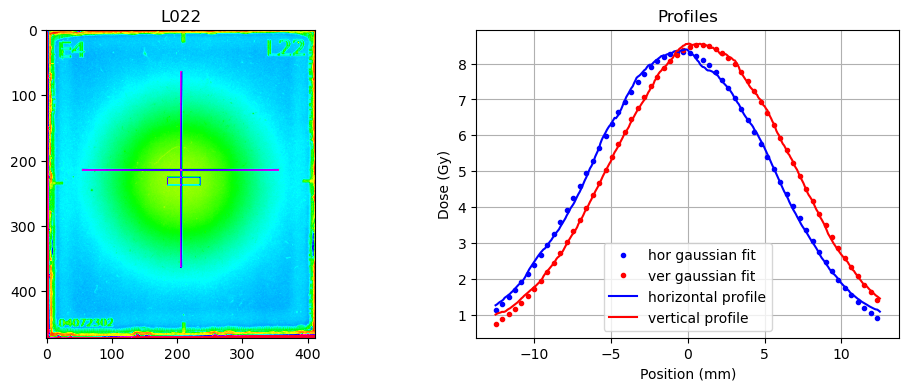

 Mean dose square :  9.58 Gy 

 gauss parameters hor:  a = 9.73 Gy, sigma = -5.72 mm, mu = -0.75
 gauss parameters ver:  a = 9.82 Gy, sigma = -5.68 mm, mu = 0.47 

(maxLoc_x, maxLoc_y) = (206, 217)


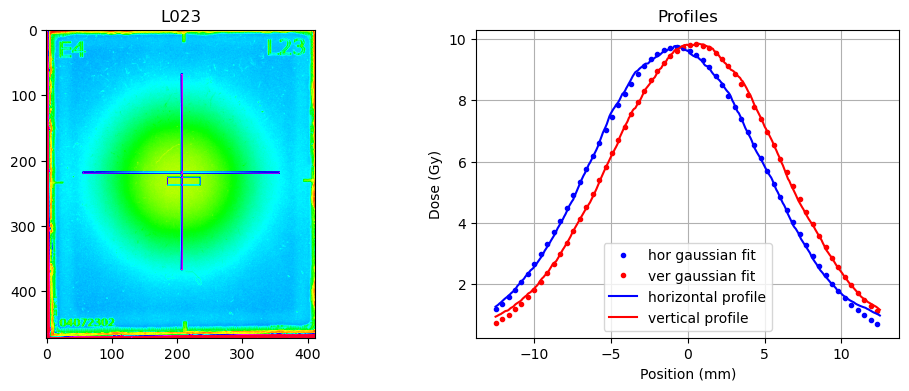

 Mean dose square :  8.57 Gy 

 gauss parameters hor:  a = 8.55 Gy, sigma = 6.17 mm, mu = -0.46
 gauss parameters ver:  a = 8.74 Gy, sigma = 6.17 mm, mu = 0.71 

(maxLoc_x, maxLoc_y) = (205, 214)


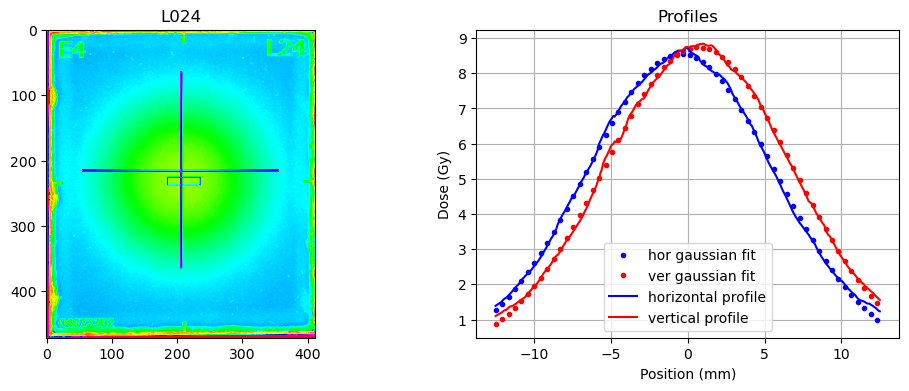

 Mean dose square :  10.64 Gy 

 gauss parameters hor:  a = 10.47 Gy, sigma = -5.53 mm, mu = -1.38
 gauss parameters ver:  a = 10.7 Gy, sigma = 5.5 mm, mu = 0.84 

(maxLoc_x, maxLoc_y) = (214, 213)


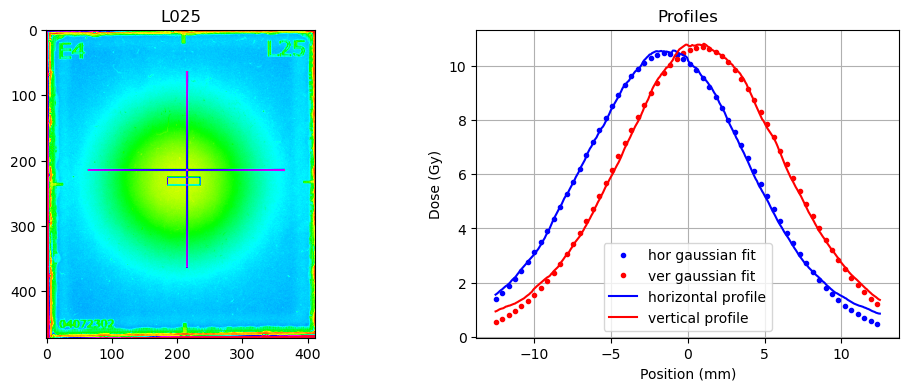

 Mean dose square :  8.67 Gy 

 gauss parameters hor:  a = 10.45 Gy, sigma = 5.72 mm, mu = 1.74
 gauss parameters ver:  a = 9.93 Gy, sigma = -5.67 mm, mu = 0.61 

(maxLoc_x, maxLoc_y) = (180, 214)


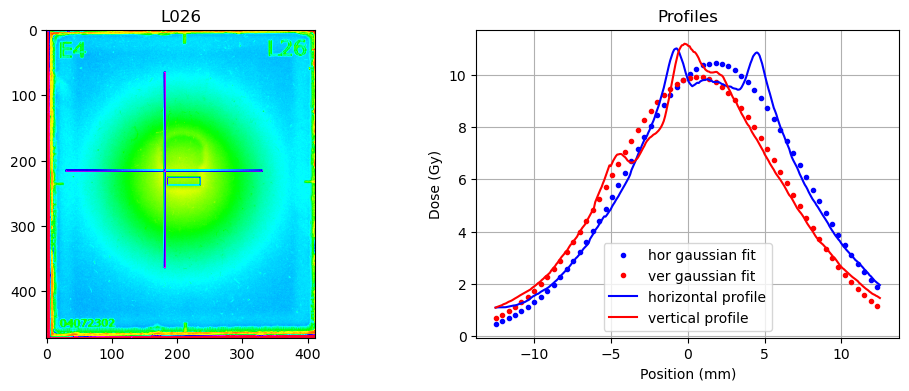

 Mean dose square :  9.97 Gy 

 gauss parameters hor:  a = 10.02 Gy, sigma = -5.71 mm, mu = -0.03
 gauss parameters ver:  a = 10.23 Gy, sigma = -5.73 mm, mu = 0.35 

(maxLoc_x, maxLoc_y) = (206, 219)


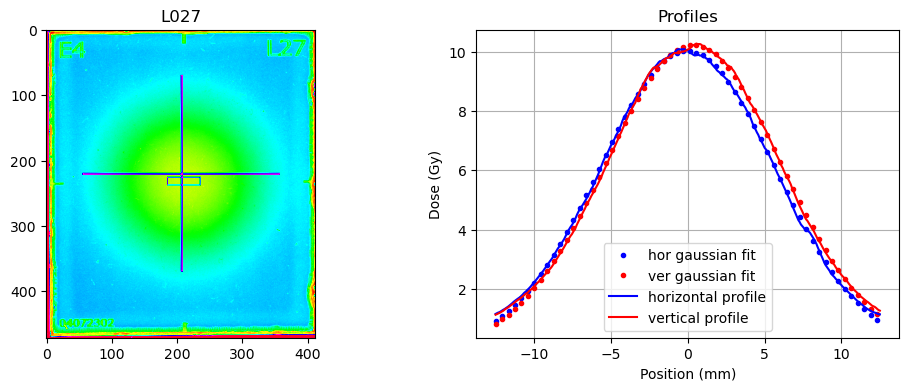

 Mean dose square :  8.04 Gy 

 gauss parameters hor:  a = 9.74 Gy, sigma = -5.92 mm, mu = 2.14
 gauss parameters ver:  a = 9.56 Gy, sigma = -5.8 mm, mu = 1.0 

(maxLoc_x, maxLoc_y) = (180, 210)


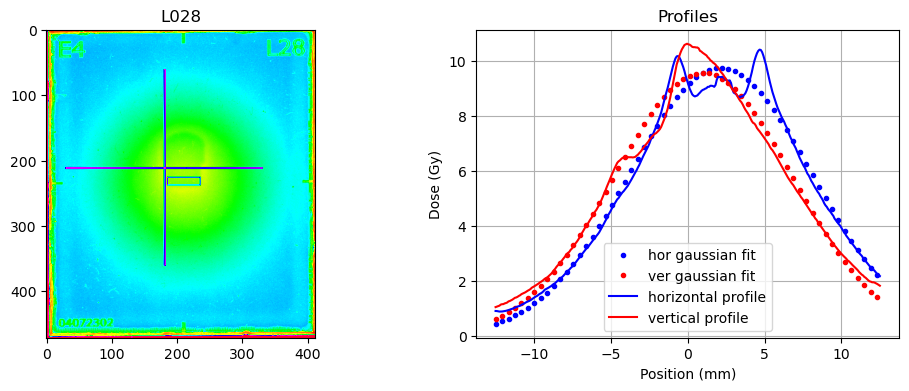

 Mean dose square :  0.13 Gy 

(maxLoc_x, maxLoc_y) = (202, 191)


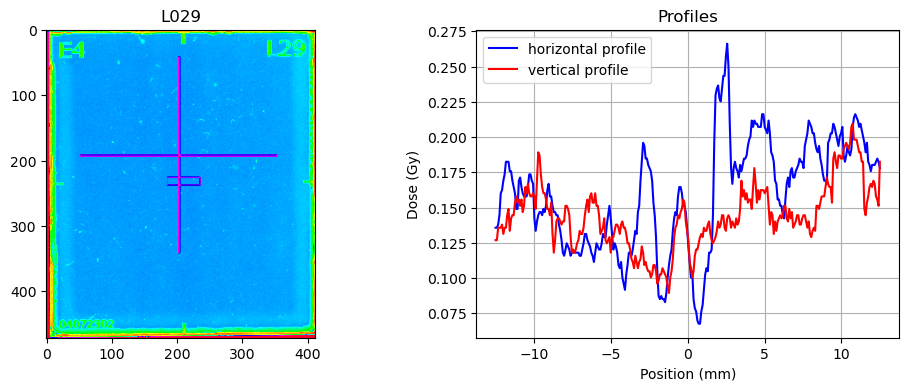

 Mean dose square :  0.11 Gy 

(maxLoc_x, maxLoc_y) = (180, 180)


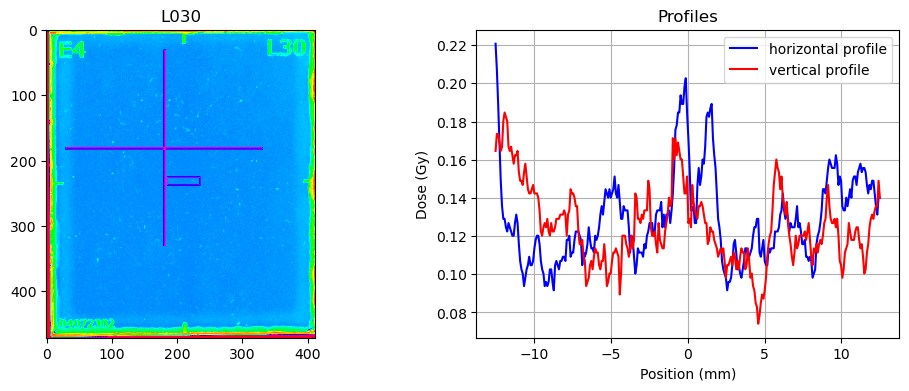

 Mean dose square :  0.18 Gy 

(maxLoc_x, maxLoc_y) = (217, 217)


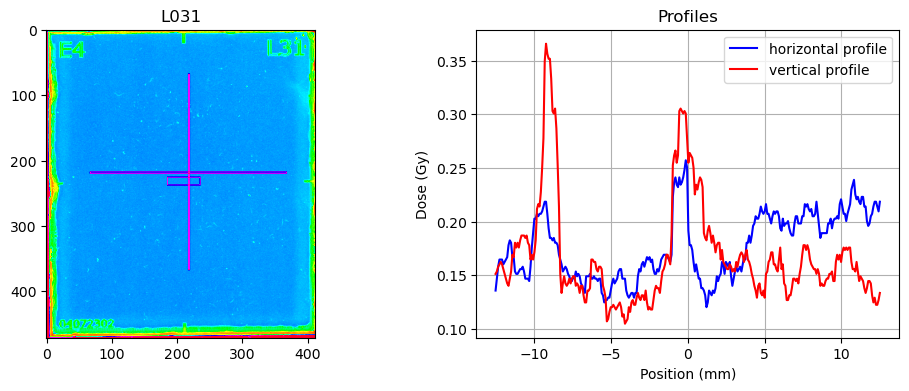

 Mean dose square :  0.23 Gy 

(maxLoc_x, maxLoc_y) = (211, 180)


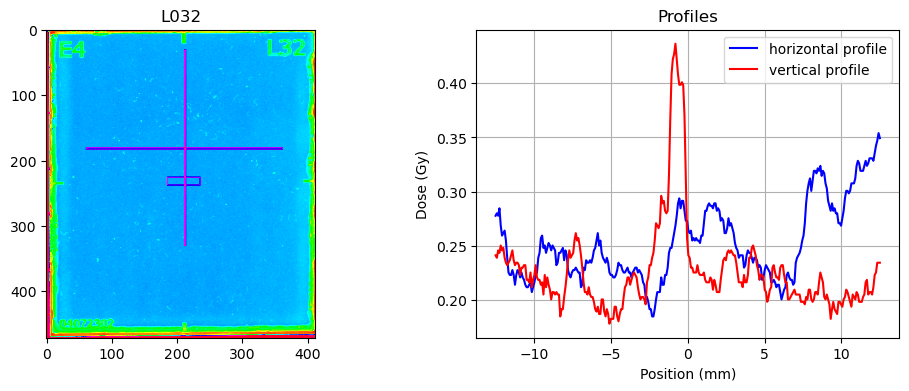

In [6]:
letter = "L"    #batch

filenames = np.sort(os.listdir(f"ZFE_{letter}"))    #Scanned batch folder

dose = []

n=0
with open(f"DoseResults/measured_dose_{letter}.txt", "w") as text_file:
    col_width = 10
    col_width_fwhm = 14
    header_format = f"{{:<{col_width}}}{{:<{col_width}}}{{:<{col_width_fwhm}}}{{:<{col_width_fwhm}}}\n"
    text_file.write(header_format.format("Film", "Dose(Gy)", "FWHM X(mm)", "FWHM Y(mm)"))

    for i in filenames:    
    
        file = f'ZFE_{letter}/{i}'
        column0 = i.replace(".tif", "")
        
        image = cv2.imread(file)
        
        # Image specs
        height, width, channels = image.shape

        mm = round(height/40)   # 1mm in pixel

        image_g = image[:, :, 1]
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if channel == "G":
            negative_image = cv2.bitwise_not(image_g)
        elif channel == "RGB":
            negative_image = cv2.bitwise_not(image_gray)
        else:
            print("channel error")
            break


        # Gaussian blur to avoid noise and locate maximum intensity pixel

        image_blur = cv2.GaussianBlur(negative_image, (7, 7), 0)

        x_zoi, y_zoi = 180, 180

        zoi = image_blur[y_zoi:220, x_zoi:220]                  #Defines a restricted search area to better avoid noise

        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(zoi)

        # Max intensity pixel coordinates
        maxLoc_x = maxLoc[0] + x_zoi
        maxLoc_y = maxLoc[1] + y_zoi                     

        # Defining Square to measure the dose in

        x, y, width, height = 185, 225, 50, 1*mm                  # -> custom square to fit the mercury
        #x, y, width, height = maxLoc_x-1, maxLoc_y-1, 3, 3       # -> square on center of mass, 3x3 pixels square here

        square = negative_image[y:y+height, x:x+width]

        mean_intensity = np.mean(square)                          # Intensity inside defined square
        
        
        #Profiles
        #horizontal slice
        x_hor, y_hor, width_hor, height_hor = maxLoc_x-150, maxLoc_y, 300, 2
        hor =  negative_image[y_hor:y_hor+height_hor, x_hor:x_hor+width_hor]

        #vertical slice
        x_ver, y_ver, width_ver, height_ver = maxLoc_x, maxLoc_y-150, 2, 300
        ver =  negative_image[y_ver:y_ver+height_ver, x_ver:x_ver+width_ver]
        
        #-> Horizontal and Vertical slices intersect on maximum intensity pixel
        
        #vertical and horizontal intensity per mm
        hor_intensity = []
        ver_intensity = []
        
        for j in range(1,width_hor):
            hor_intensity.append(np.mean(negative_image[y_hor:y_hor+height_hor, x_hor+j:x_hor+j+12]))   

        for j in range(1,height_ver):
            ver_intensity.append(np.mean(negative_image[y_ver+j:y_ver+j+12, x_ver:x_ver+width_ver]))
        
        #vertical and horizontal dose per mm
        hor_dose = []
        ver_dose = []

        for j in range(1, width_hor-1) :
            hor_dose.append(D(ItoOD(hor_intensity[j]), *popt))
            
        for j in range(1, height_ver-1):
            ver_dose.append(D(ItoOD(ver_intensity[j]), *popt))

            
            
        #Display and Gaussian fit
        
        result = cv2.rectangle(negative_image, (x,y), (x+width, y+height), (0,255,0), 1)
        result_hor = cv2.rectangle(negative_image, (x_hor,y_hor), (x_hor+width_hor, y_hor+height_hor), (0,255,0), 1)
        result_ver = cv2.rectangle(negative_image, (x_ver,y_ver), (x_ver+width_ver, y_ver+height_ver), (0,255,0), 1)
        
        #print("\033[1m Mean intensity square : \033[0m", mean_intensity, "\n")
        print(f"\033[1m Mean dose square : \033[0m", round(D(ItoOD(mean_intensity), *popt), 2), "Gy \n")
        
        def gauss(x, a, sigma, mu):
            return a*np.exp(-(x-mu)**2/(2*sigma**2))
        
        interval = np.linspace(-width_hor/2, width_hor/2, width_hor-2)
        interval_mm = interval/12  #Conversion en millimètres
        
        fig, axs = plt.subplots(1,2, figsize=(12, 4))
        axs = axs.ravel()

        dose.append(round(D(ItoOD(mean_intensity), *popt), 2))
        
        if dose[n] > 1: #condition to avoid fitting on background films
        
            popt_hor, pcov_hor = curve_fit(gauss, interval_mm, hor_dose)
            popt_ver, pcov_ver = curve_fit(gauss, interval_mm, ver_dose)

            a_hor, sigma_hor, mu_hor = popt_hor
            a_ver, sigma_ver, mu_ver = popt_ver

            axs[1].plot(interval_mm[::5], gauss(interval_mm[::5], *popt_hor),".", color="blue",  label="hor gaussian fit")
            axs[1].plot(interval_mm[::5], gauss(interval_mm[::5], *popt_ver),".", color="red",  label="ver gaussian fit")

            print(f"\033[1m gauss parameters hor: \033[0m a = {round(a_hor, 2)} Gy, sigma = {round(sigma_hor, 2)} mm, mu = {round(mu_hor, 2)}")
            print(f"\033[1m gauss parameters ver: \033[0m a = {round(a_ver, 2)} Gy, sigma = {round(sigma_ver, 2)} mm, mu = {round(mu_ver, 2)} \n")
            column2 = 2*np.sqrt(2*np.log(2))*abs(round(sigma_hor, 2))
            column3 = 2*np.sqrt(2*np.log(2))*abs(round(sigma_ver, 2))
        else:
            column2 = 0
            column3 = 0            
        n+=1

        axs[0].imshow(result, cmap="hsv_r")
        axs[0].set_title(column0)
        
        axs[1].plot(interval_mm, hor_dose, color="blue", label="horizontal profile")
        axs[1].plot(interval_mm, ver_dose, color="red",  label="vertical profile")
        axs[1].set_xlabel("Position (mm)")
        axs[1].set_ylabel("Dose (Gy)")
        axs[1].set_title("Profiles")
        axs[1].grid(True)
        axs[1].legend()
        
        print("(maxLoc_x, maxLoc_y) =", (maxLoc_x, maxLoc_y))
        plt.show()
        
        #txt file
        
        column1 = round(D(ItoOD(mean_intensity), *popt), 2)
        
        
        line_format = f"{{:<{col_width}}}{{:<{col_width}.2f}}{{:<{col_width_fwhm}.2f}}{{:<{col_width_fwhm}.2f}}\n"
        text_file.write(line_format.format(column0, column1, column2, column3))